In [48]:
# Uncomment and run to reload libs
# import importlib
# import utils
# importlib.reload(utils)
# import utils.miscellaneous
# importlib.reload(utils.miscellaneous)


import gc
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import (
    logging,
    RECOMMENDED_MUTATIONS_FILE,
    FUTURE_COMBO_FILE,
)


In [ ]:
with open(FUTURE_COMBO_FILE, "br") as f:
    future_combo = pickle.load(f)


In [53]:
dated_combo = []

for c_date, c_date_combo in future_combo.items():
    logging.info(f"Future date: {c_date}")
    c_date_combo = pd.DataFrame(c_date_combo)
    c_date_combo = c_date_combo.rename(columns={0: "Accession", 1: "Mut"})
    ac_str_split = c_date_combo["Accession"].str.split("_").str
    c_date_combo["Ref_protein"] = ac_str_split[0]
    c_date_combo["Ref_pos"] = ac_str_split[1].str.extract(r"(\d+)").astype(int)

    ac_str_split = c_date_combo["Mut"].str.split("_").str
    c_date_combo["Protein"] = ac_str_split[0]
    c_date_combo["Pos"] = ac_str_split[1].str.extract(r"(\d+)").astype(int)

    c_date_combo["Ref_pos_greater"] = ((c_date_combo["Protein"] == c_date_combo["Ref_protein"]) &
                                       (c_date_combo["Ref_pos"] > c_date_combo["Pos"]))

    c_date_combo["Accession"], c_date_combo["Mut"] = np.where(
        c_date_combo["Ref_pos_greater"],
        [c_date_combo["Mut"], c_date_combo["Accession"]],
        [c_date_combo["Accession"], c_date_combo["Mut"]],
    )
    del c_date_combo["Ref_protein"], c_date_combo["Ref_pos"], c_date_combo[
        "Protein"], c_date_combo["Pos"], c_date_combo["Ref_pos_greater"]
    gc.collect()
    c_date_combo["Date"] = c_date
    dated_combo.append(c_date_combo)

dated_combo = pd.concat(dated_combo)


In [68]:
pred_scores = pd.read_csv(RECOMMENDED_MUTATIONS_FILE)
pred_scores = pd.merge(dated_combo, pred_scores, on=["Accession", "Mut"], how="inner")


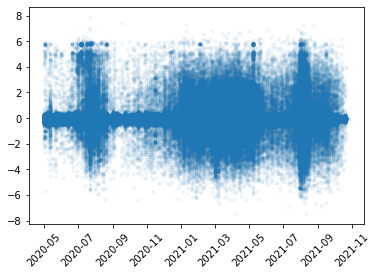

In [83]:
plt.plot_date(pred_scores["Date"], pred_scores["value"], fmt=".", alpha=0.05)
plt.xticks(rotation=45)
plt.show()
plt.close()